# LSTM (Long Short-Term Memory) ile Hisse Senedi Tahmini

1.   İş Problemi (Business Problem)
2.   Veriyi Anlama (Data Understanding)
3.   Veriyi Hazırlamak (Data Preparation)
4.   Modelleme (Modeling)
5.   Değerleme (Evaluation)



# İş Problemi (Business Problem)

**Date**: İlgili işlem gününün tarihini ifade eder.<br>
**Open**: Payın ilgili işlem gününde başlangıç fiyatını ifade eder.<br>
**High**: İlgili işlem gününde en yüksek fiyatı ifade eder.<br>
**Low**: İlgili işlem gününde en düşük fiyatı temsil eder.<br>
**Close**: Payın ilgili işlem günündeki kapanış fiyatını ifade eder.<br>
**Adj Close**: Hisse senedinin söz konusu işlem gününde düzeltilmiş kapanış fiyatını temsil eder.<br>
**Volume**: İlgili işlem gününe ait işlem hacmi bilgisini temsil eder.

# Veriyi Anlama (Data Understanding)

In [1]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Model değerlendirme ve veriyi scale edebilmemiz için kullanılacak olan kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

# Tensorflow Warning Engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [ ]:
df = pd.read_csv('/content/ASELS.IS.csv')
df.head()

In [3]:
def check_df(dataframe, size=5):
    print('\n\n--- Shape -----------------------------------------------------------------------')
    print(dataframe.shape)
    print('\n\n--- Types -----------------------------------------------------------------------')
    print(dataframe.dtypes)
    print('\n\n--- Head ------------------------------------------------------------------------')
    print(dataframe.head(size))
    print('\n\n--- Tail ------------------------------------------------------------------------')
    print(dataframe.tail(size))
    print('\n\n--- NA --------------------------------------------------------------------------')
    print(dataframe.isnull().sum())
    print('\n\n--- Quantiles -------------------------------------------------------------------')
    print(df.drop('Date', axis=1).quantile([0, 0.05, 0.5, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df.head()

In [7]:
aselsan_df = df[["Date","Close"]]

In [8]:
aselsan_df.tail()

,Date,Close
4962,2024-04-26,59.099998
4963,2024-04-29,62.049999
4964,2024-04-30,60.750000
4965,2024-05-02,62.099998
4966,2024-05-03,62.200001


In [9]:
print("Minimum Tarih :" , aselsan_df["Date"].min())
print("Maximmum Tarih :" , aselsan_df["Date"].max())

Minimum Tarih : 2005-01-03 00:00:00
Maximmum Tarih : 2024-05-03 00:00:00


In [10]:
aselsan_df.index = aselsan_df["Date"]

In [11]:
aselsan_df.drop("Date",axis=1,inplace=True)

In [ ]:
aselsan_df

In [13]:
history_df = aselsan_df.copy()

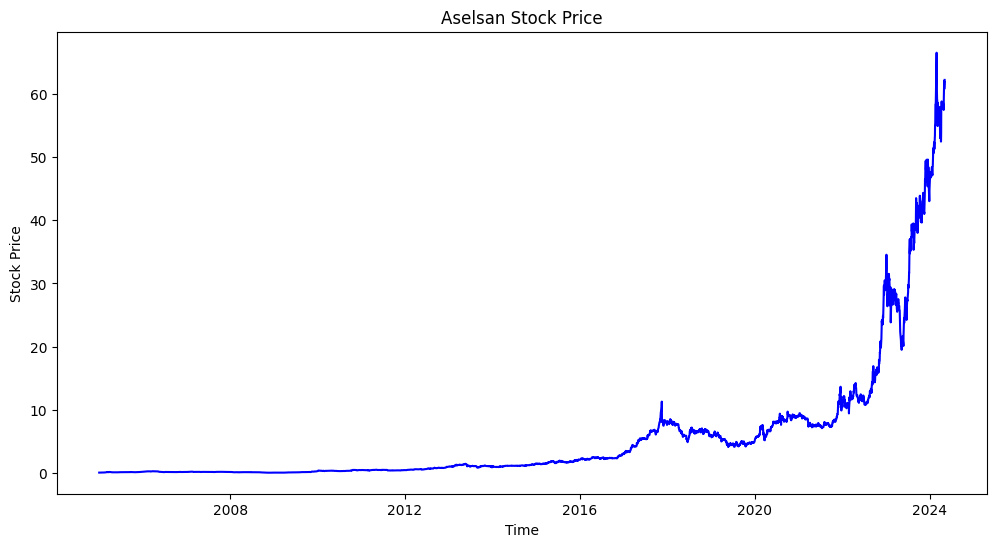

In [14]:
plt.figure(figsize=(12,6))
plt.plot(aselsan_df['Close'],color='blue')
plt.ylabel('Stock Price')
plt.title('Aselsan Stock Price')
plt.xlabel('Time')
plt.show();

In [15]:
aselsan_df = aselsan_df.values # numpy.ndarray'e çevirdik

In [16]:
aselsan_df[0:5]

array([[0.08674],
       [0.08821],
       [0.08674],
       [0.08821],
       [0.08821]])

In [17]:
aselsan_df=aselsan_df.astype('float32')

In [18]:
#Train ve Test Setinin ayrılması

def split_data(dataframe,test_size):
  pos = int(round(len(dataframe)*(1-test_size)))
  train = dataframe[:pos]
  test = dataframe[pos:]
  return train,test,pos

In [19]:
train,test,pos = split_data(aselsan_df,0.20)   # Train %80 Test : %20 verdik.

In [20]:
print(train.shape,test.shape)

(3974, 1) (993, 1)


In [21]:
scaler_train = MinMaxScaler(feature_range=(0,1))

In [22]:
train = scaler_train.fit_transform(train)

In [23]:
scaler_test = MinMaxScaler(feature_range=(0,1))

In [24]:
test = scaler_test.fit_transform(test)

In [ ]:
train[0:5]
test[0:5]

In [26]:
def create_features(data,lookback):
  X,Y= [],[]
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [27]:
lookback =20

In [28]:
# Train
x_train, y_train = create_features(train, lookback)

# Test
x_test, y_test = create_features(test, lookback)

In [29]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(3954, 20) (3954,) (973, 20) (973,)


In [30]:
x_train[0:5] # 20 önceki günü aldık.

array([[0.00151654, 0.00164726, 0.00151654, 0.00164726, 0.00164726,
        0.00177799, 0.00190871, 0.00184335, 0.00190871, 0.00203943,
        0.00197407, 0.00210479, 0.00236632, 0.00236632, 0.00236632,
        0.00236632, 0.00230096, 0.00243168, 0.00269312, 0.00275848],
       [0.00164726, 0.00151654, 0.00164726, 0.00164726, 0.00177799,
        0.00190871, 0.00184335, 0.00190871, 0.00203943, 0.00197407,
        0.00210479, 0.00236632, 0.00236632, 0.00236632, 0.00236632,
        0.00230096, 0.00243168, 0.00269312, 0.00275848, 0.00269312],
       [0.00151654, 0.00164726, 0.00164726, 0.00177799, 0.00190871,
        0.00184335, 0.00190871, 0.00203943, 0.00197407, 0.00210479,
        0.00236632, 0.00236632, 0.00236632, 0.00236632, 0.00230096,
        0.00243168, 0.00269312, 0.00275848, 0.00269312, 0.00275848],
       [0.00164726, 0.00164726, 0.00177799, 0.00190871, 0.00184335,
        0.00190871, 0.00203943, 0.00197407, 0.00210479, 0.00236632,
        0.00236632, 0.00236632, 0.00236632, 0

In [31]:
y_train[0:5]

array([0.00269312, 0.00275848, 0.00262776, 0.00269312, 0.0025624 ],
      dtype=float32)

In [32]:
# Veri setlerini 3 boyutlu yapıya getirme
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3954, 1, 20) (3954, 1) (973, 1, 20) (973, 1)


# MODELLEME

In [33]:
# Model kurulumu
model = Sequential()
model.add(LSTM(units=50, #50 nöron olacak
               activation='relu',
               input_shape=(x_train.shape[1], lookback)))
model.add(Dropout(0.2)) # aşırı öğrenmeyi engelleyecek kısım
model.add(Dense(1))

In [ ]:
model.summary()

In [35]:
# Optimizasyon ve değerlendirme metriklerinin ayarlanması
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]

In [37]:
# Model fit
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
187/198 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 1: val_loss improved from inf to 0.00584, saving model to mymodel.h5
198/198 [==============================] - 3s 8ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 2/100
190/198 [===========================>..] - ETA: 0s - loss: 0.0025
Epoch 2: val_loss improved from 0.00584 to 0.00152, saving model to mymodel.h5
198/198 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 3/100
180/198 [==========================>...] - ETA: 0s - loss: 0.0015    
Epoch 3: val_loss improved from 0.00152 to 0.00144, saving model to mymodel.h5
198/198 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 4/100
192/198 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 4: val_loss improved from 0.00144 to 0.00114, saving model to mymodel.h5
198/198 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/100
187/

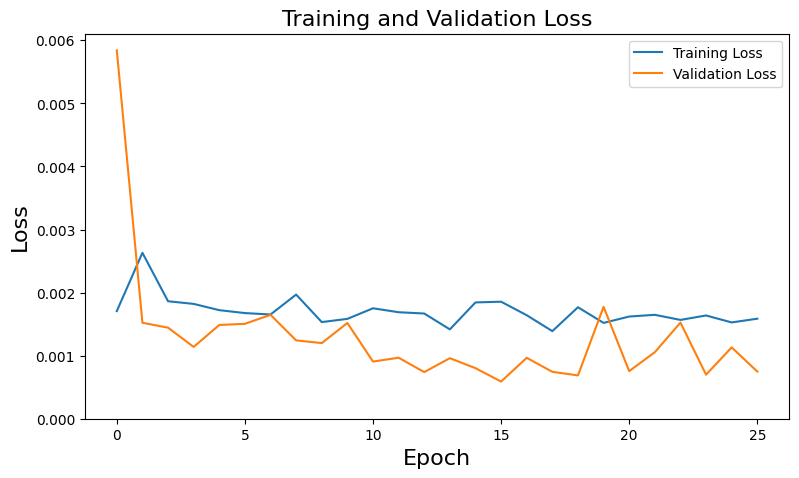

In [38]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# DEĞERLENDİRME

In [39]:
loss = model.evaluate(x_test, y_test, batch_size=20)
print('\nTest Loss: %.1f%%' % (100.0 * loss))

49/49 [==============================] - 0s 2ms/step - loss: 7.4780e-04

Test Loss: 0.1%


In [40]:
# Modelimizden tahminleri alıyoruz
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

31/31 [==============================] - 0s 1ms/step


In [41]:
# Standartlaştırılmış tahmin verilerini gerçek değerlere geri dönüştürüyoruz
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [42]:
# Yukarıdaki aynı işlemi eğitilen ve test edilen veri setlerine de yapıyoruz
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [43]:
# Train RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [44]:
# Test RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [45]:
print(f'Train RMSE: {train_rmse}')
print(f' Test RMSE: {test_rmse}')

Train RMSE: 0.2835521101951599
 Test RMSE: 1.6240736246109009


In [60]:
# Gerçek değerler ile tahmin edilen değerleri train veri seti için kıyaslama
train_prediction_df = history_df[lookback:pos]
train_prediction_df['Predicted'] = train_predict
train_prediction_df.tail()


,Close,Predicted
Date,,
2020-05-06,6.720,6.991011
2020-05-07,6.725,6.984588
2020-05-08,6.630,6.964515
2020-05-11,6.700,6.946921
2020-05-12,6.865,6.943023


In [52]:
# Gerçek değerler ile tahmin edilen değerleri test veri seti için kıyaslama
test_prediction_df = history_df[pos+lookback:] # pos+lookback yani trainden sonraki kısmı aldık
test_prediction_df['Predicted'] = test_predict
test_prediction_df.tail()

,Close,Predicted
Date,,
2024-04-26,59.099998,56.839470
2024-04-29,62.049999,57.127487
2024-04-30,60.750000,58.110500
2024-05-02,62.099998,58.573910
2024-05-03,62.200001,59.168491


In [47]:
# Veri setinin en güncel tarihteki test tahminleri
test_prediction_df.tail(10)

,Close,Predicted
Date,,
2024-04-18,57.650002,56.042892
2024-04-19,58.700001,56.268337
2024-04-22,57.799999,56.718075
2024-04-24,58.299999,56.872280
2024-04-25,57.450001,56.851685
2024-04-26,59.099998,56.839470
2024-04-29,62.049999,57.127487
2024-04-30,60.750000,58.110500
2024-05-02,62.099998,58.573910


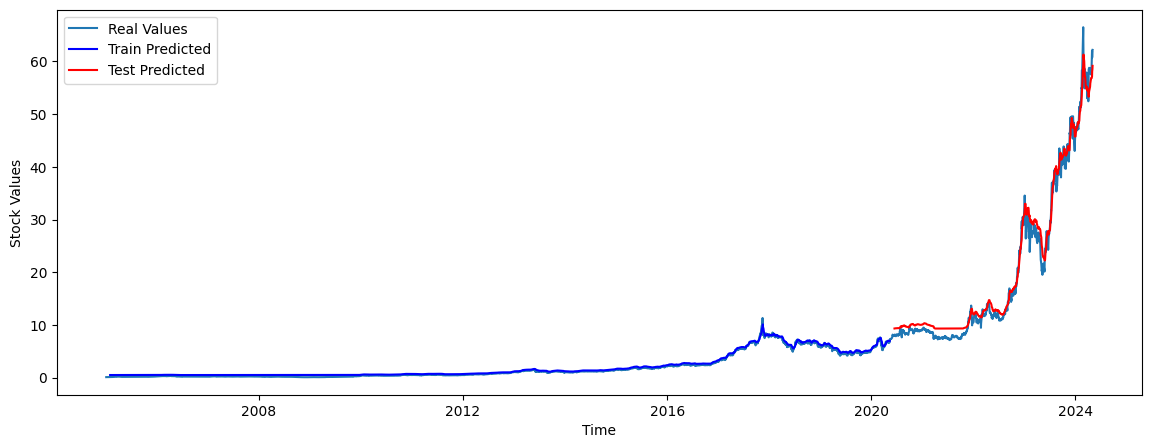

In [62]:
# Train ve Test Tahminlerini ayrı ayrı görselleştirme
plt.figure(figsize=(14, 5))
plt.plot(history_df, label='Real Values')
plt.plot(train_prediction_df['Predicted'], color='blue', label='Train Predicted')
plt.plot(test_prediction_df['Predicted'], color='red', label='Test Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.legend()
plt.show()

In [63]:
# Tahmin için gerekli olan kütüphaneleri ekleyelim
from datetime import datetime

# 2025 yılına ait bir tarih oluşturalım
future_date = datetime(2025, 1, 1)

# Son 20 günü alıp numpy array yapısına dönüştürelim
last_20_days = aselsan_df[-20:].reshape(1, 1, 20)

# Modeli kullanarak tahmin yapalım
predicted_value = model.predict(last_20_days)

# Tahminin tersine dönüştürülmesi
predicted_price = scaler_test.inverse_transform(predicted_value)

# Tahmin edilen fiyatı ekrana yazdıralım
print("2025 yılı için tahmin edilen Aselsan hisse değeri:", predicted_price[0][0])


1/1 [==============================] - 0s 48ms/step
2025 yılı için tahmin edilen Aselsan hisse değeri: 1179.2328
